**Import libraries**

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

init_notebook_mode(connected=True)

# Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)

2024-05-12 15:39:59.792856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 15:39:59.792946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 15:39:59.906998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load Data and Plot Samples**

In [3]:
TRAIN_DIR = ('/kaggle/input/facial-recognition-dataset/Training/Training/')
TEST_DIR = ('/kaggle/input/facial-recognition-dataset/Testing/Testing/')

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    labels = dict()
    i = 0
    
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = img.astype('float32') / 255
                        resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                        X.append(resized)
                        y.append(i)
                    else:
                        print(f"Error loading image: {img_path}")
            i += 1
    
    return np.array(X), np.array(y), labels

# Usage example:
TRAIN_DIR = ('/kaggle/input/facial-recognition-dataset/Training/Training/')
IMG_SIZE = (48, 48)  # Example image size
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [02:49<00:00, 28.17s/it]


In [5]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [6]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:36<00:00,  6.05s/it]


In [7]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

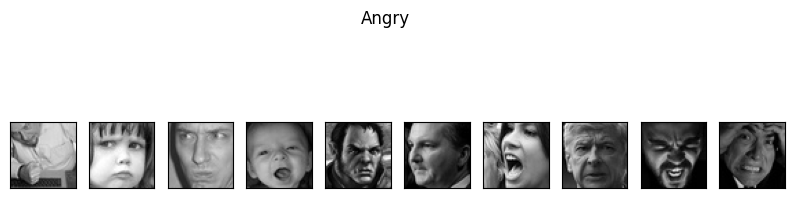

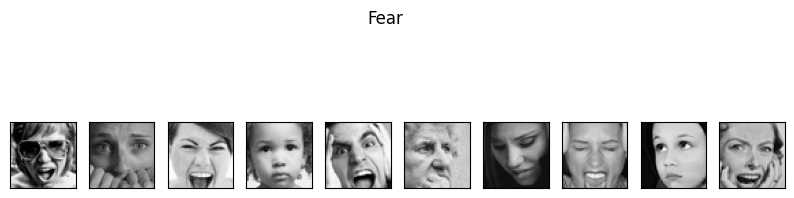

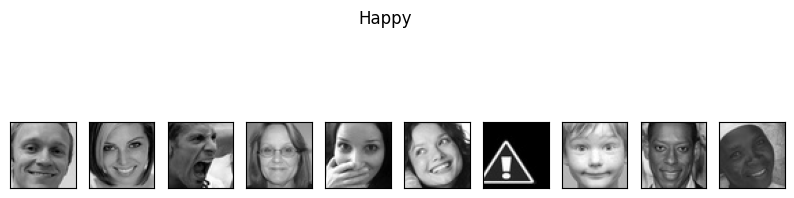

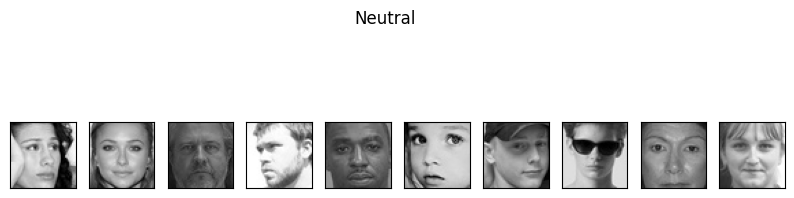

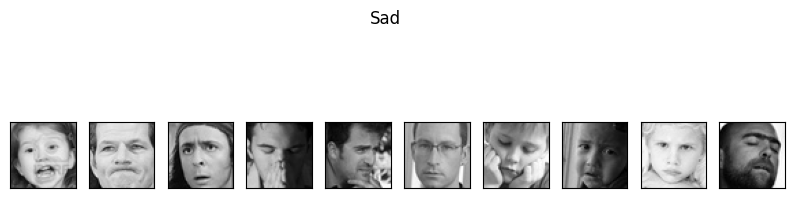

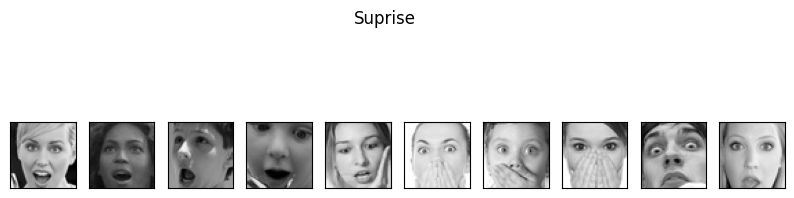

In [8]:
plot_samples(X_train, y_train, train_labels, 10)

In [9]:
from keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
print(Y_train.shape)

(28273, 6)


In [10]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

## Model with no weights 

In [11]:
from keras.applications.vgg16 import VGG16

# Path to the ImageNet weights file
weights_path = '/kaggle/input/imagenet/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG16(
    weights=weights_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [13]:
def deep_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size):
    # Check input shapes
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    
    # Fit the model
    history = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),  # Use X_val, Y_val for validation
        verbose=1
    )
    
    return history

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [15]:
history = deep_model(model, X_train, Y_train, X_test, Y_test, epochs=48, batch_size=32)

X_train shape: (28273, 48, 48, 3)
Y_train shape: (28273, 6)
X_val shape: (7067, 48, 48, 3)
Y_val shape: (7067, 6)
Epoch 1/48
  2/884 ━━━━━━━━━━━━━━━━━━━━ 49s 57ms/step - accuracy: 0.0469 - loss: 0.8048   

I0000 00:00:1715528716.702044     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715528716.726159     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3613 - loss: 0.4044

W0000 00:00:1715528756.325868     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715528757.717963     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


884/884 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.3614 - loss: 0.4043 - val_accuracy: 0.5496 - val_loss: 0.3143
Epoch 2/48
  3/884 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.5920 - loss: 0.3025

W0000 00:00:1715528763.129213     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


884/884 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.5698 - loss: 0.3015 - val_accuracy: 0.5964 - val_loss: 0.2835
Epoch 3/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.6387 - loss: 0.2650 - val_accuracy: 0.6164 - val_loss: 0.2817
Epoch 4/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.6918 - loss: 0.2330 - val_accuracy: 0.6181 - val_loss: 0.2982
Epoch 5/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.7523 - loss: 0.1969 - val_accuracy: 0.5983 - val_loss: 0.3202
Epoch 6/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.7916 - loss: 0.1693 - val_accuracy: 0.5790 - val_loss: 0.4094
Epoch 7/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8239 - loss: 0.1452 - val_accuracy: 0.6038 - val_loss: 0.3956
Epoch 8/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8582 - loss: 0.1201 - val_accuracy: 0.6172 - val_loss: 0.3846
Epoch 9/48
884/884 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8854 - loss: 0.0990 - val_accurac

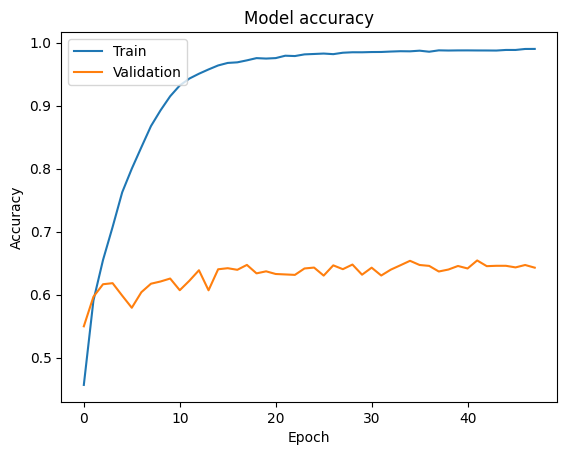

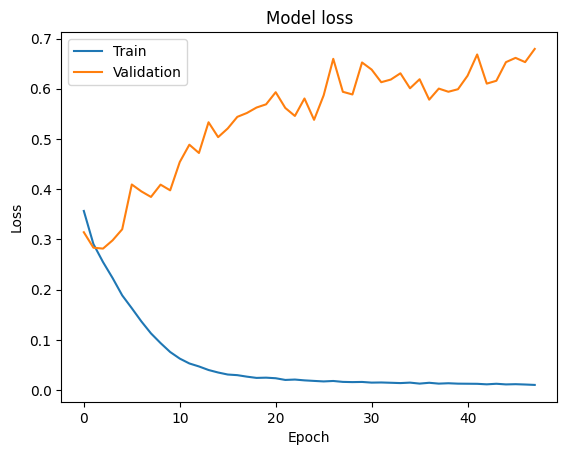

In [16]:
plot_metrics(history)

In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

 13/221 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

W0000 00:00:1715530559.902513     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


W0000 00:00:1715530562.920278     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy = 0.64


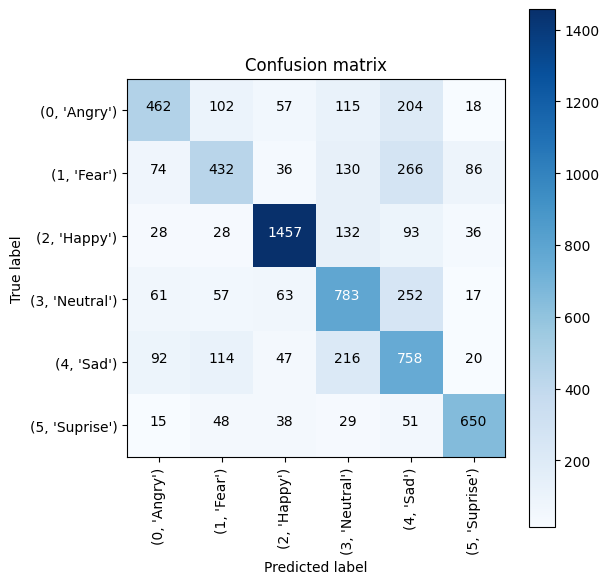

In [18]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

Test Loss: 0.6793732643127441
Test Accuracy: 0.6427055597305298
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


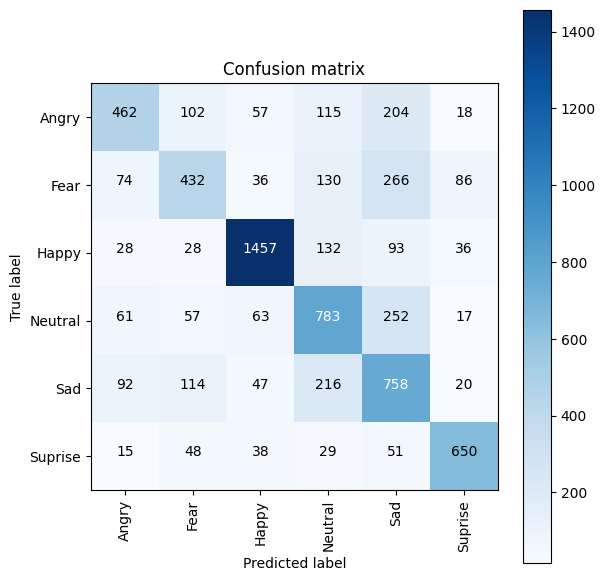

              precision    recall  f1-score   support

       Angry       0.63      0.48      0.55       958
        Fear       0.55      0.42      0.48      1024
       Happy       0.86      0.82      0.84      1774
     Neutral       0.56      0.64      0.59      1233
         Sad       0.47      0.61      0.53      1247
     Suprise       0.79      0.78      0.78       831

    accuracy                           0.64      7067
   macro avg       0.64      0.63      0.63      7067
weighted avg       0.65      0.64      0.64      7067



In [19]:
def evaluate_model(model, X_test, y_test, test_labels):
    # Evaluate on test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)

    # Confusion matrix
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plot_confusion_matrix(confusion_mtx, classes=list(test_labels.values()), normalize=False)

    # Classification report
    target_names = list(test_labels.values())
    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

evaluate_model(model, X_test, Y_test, test_labels)


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your batch size
batch_size = 32  # or whatever batch size you want to use

datagen_test = ImageDataGenerator(rescale=1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                   target_size=(48, 48),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=False)

Found 7067 images belonging to 6 classes.


In [21]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [22]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [23]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Sad,Angry
1,Angry/Angry-10.jpg,Angry,Angry
2,Angry/Angry-100.jpg,Angry,Angry
3,Angry/Angry-101.jpg,Fear,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


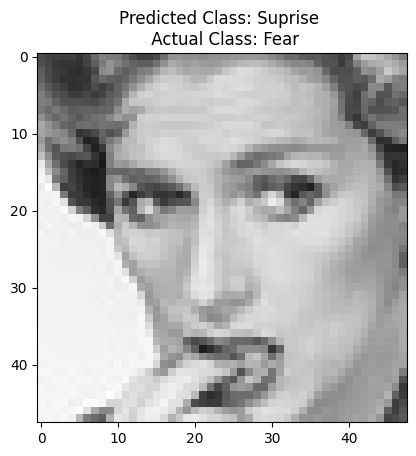

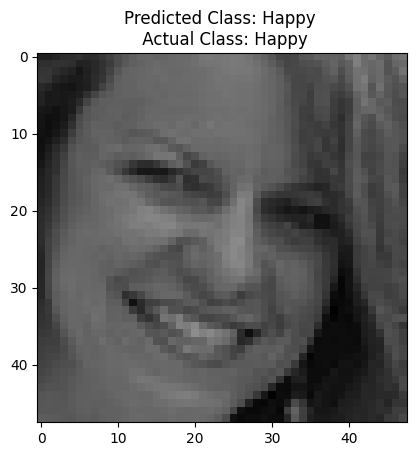

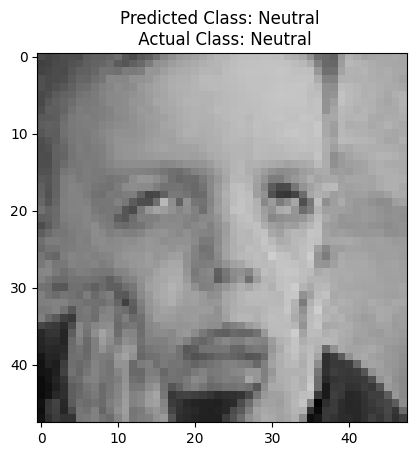

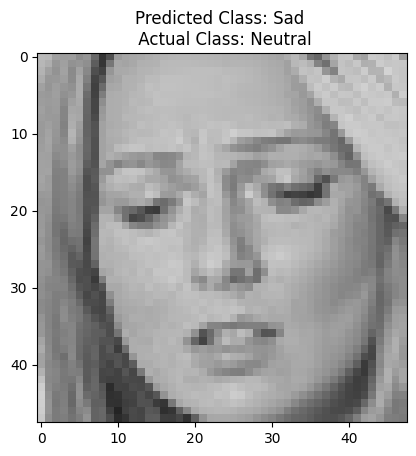

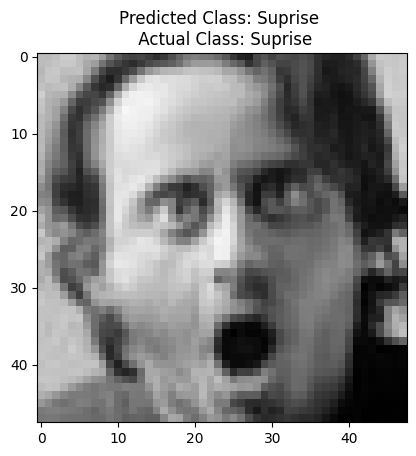

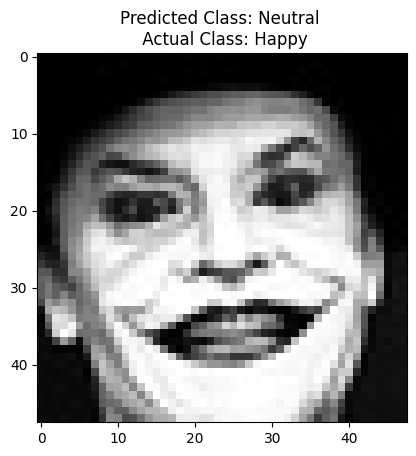

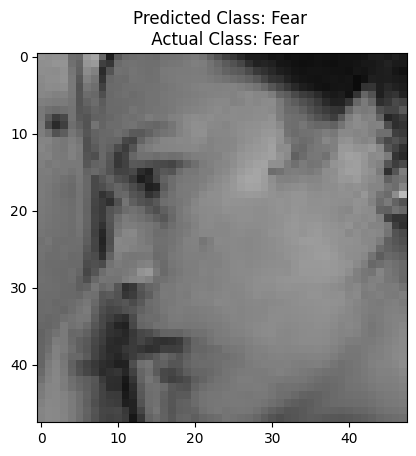

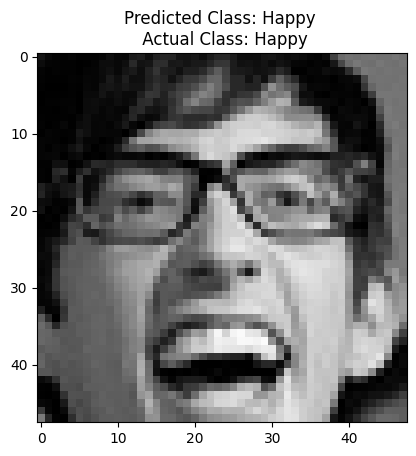

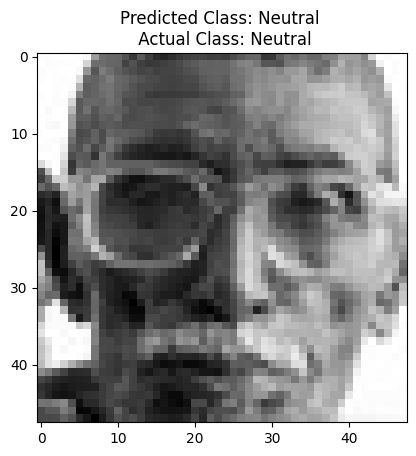

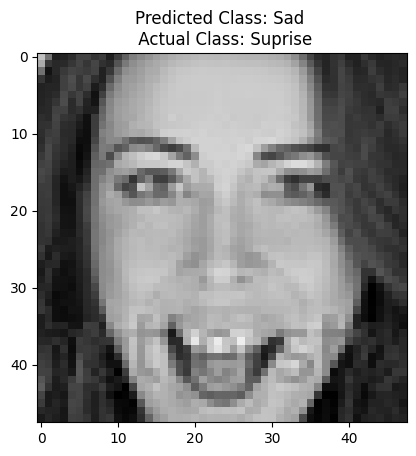

In [24]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass